# Problem: Forecasting Stock Prices using Machine Learning Algorithms

## Method: ANN
## Data: Stock market prices from Investing.com
## Libraries:
- numpy
- tensorflow
- random
- seaborn
- matplotlib
- scikit-learn (sklearn)
- pandas
- statsmodels
- scipy

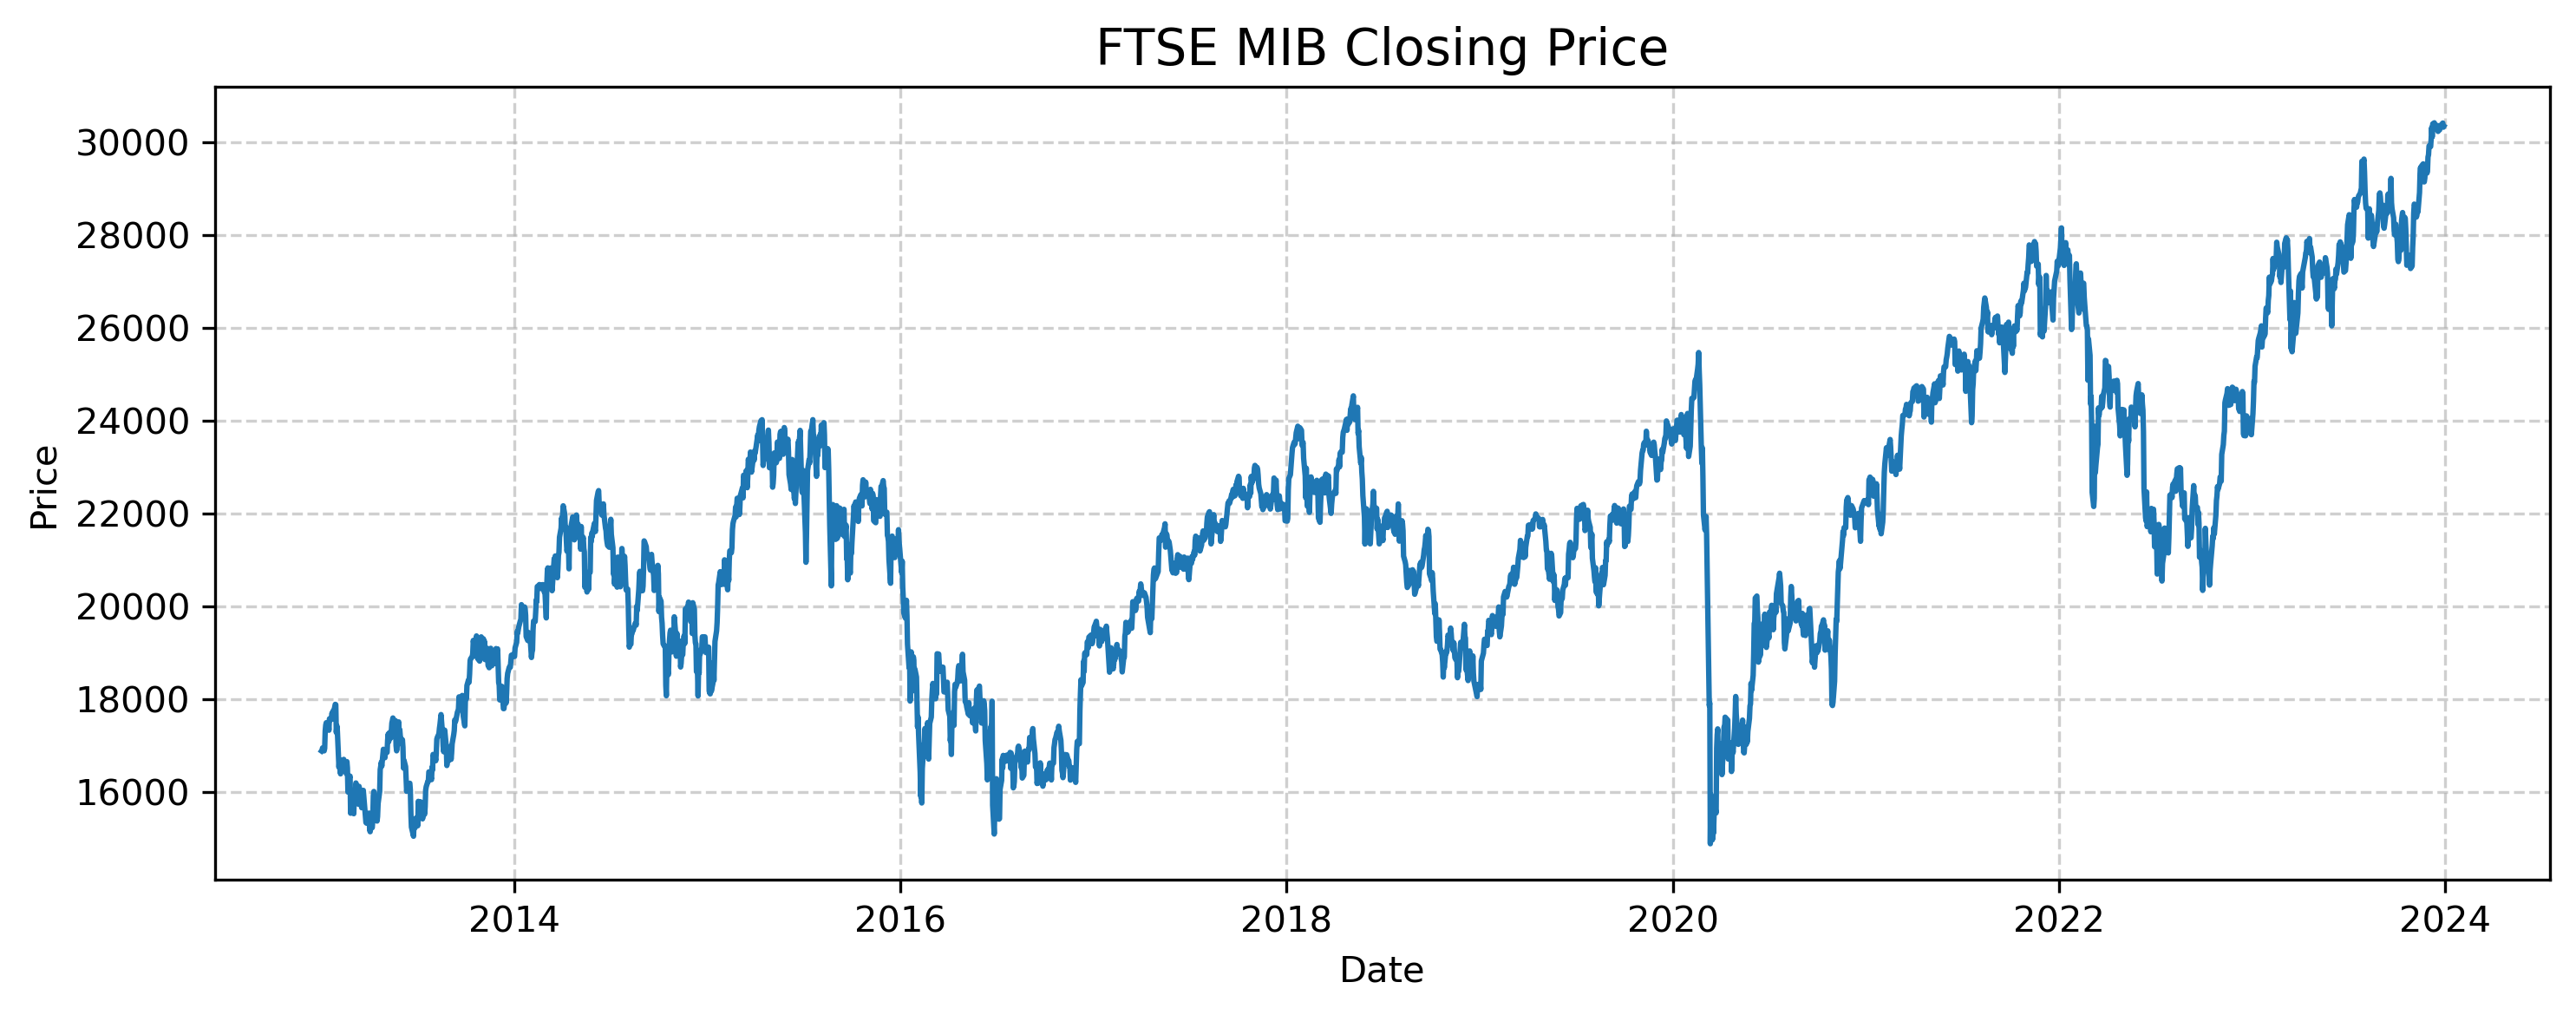

Training samples: 2188, Test samples: 562
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test RMSE: 356.05
Test MAE: 272.31
Test MAPE: 1.08%
Test R^2: 0.9803
Residual Ljung-Box p-value (lag 10): 0.0000
t-test p-value: 0.1438
Residual Mean: 21.9605


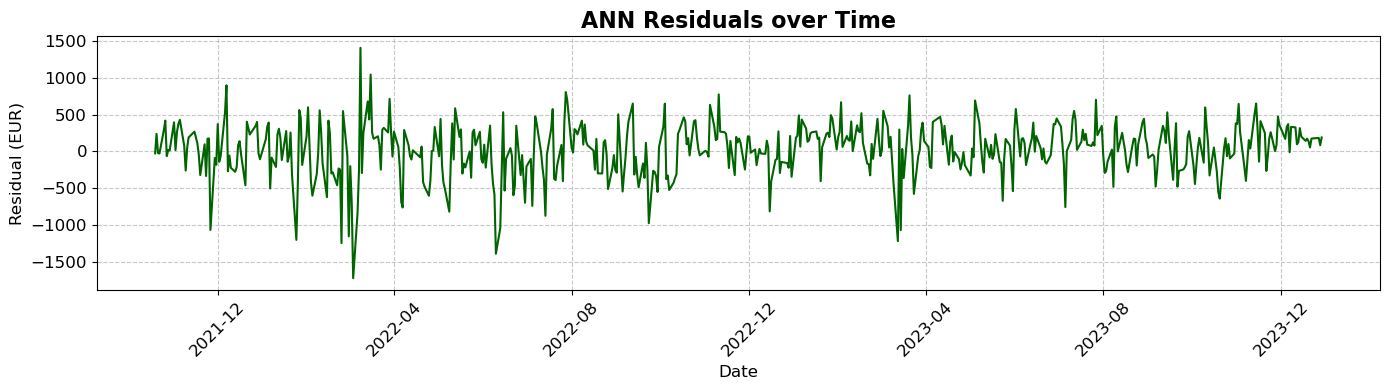

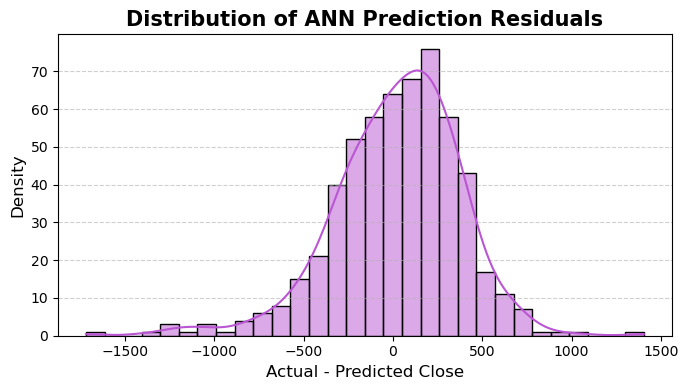

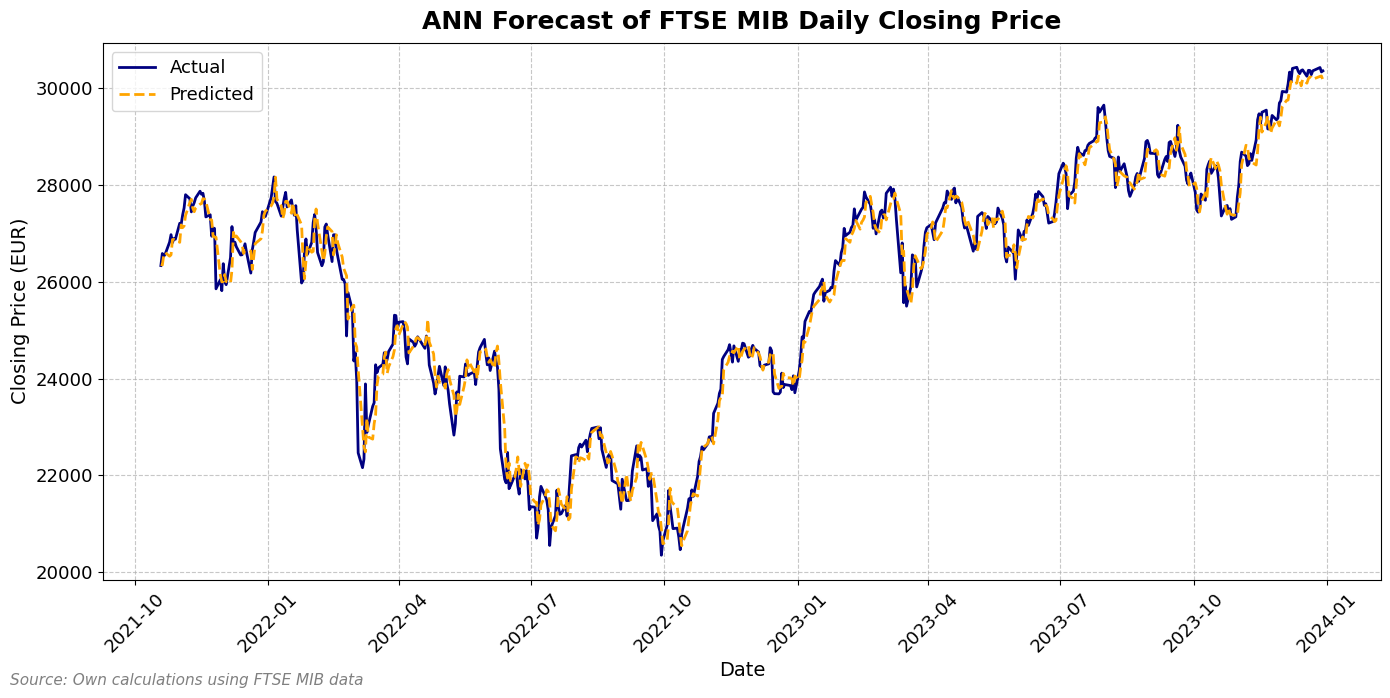

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Next day predicted close: 30212.52


In [1]:
"""Feedforward ANN forecasting of the FTSE MIB closing price.

This script loads the daily closing prices from ``dataftsemib_manual.csv``,
cleans the numeric fields, and prepares sequences of the previous 60 closes
to predict the next day's close. A simple multi-layer perceptron is trained
on the training portion (80%) and evaluated on the remaining 20%.  The script
prints RMSE, MAE, MAPE and R^2 metrics and plots the predicted vs. actual
closing prices for the test set.
"""
import numpy as np
import tensorflow as tf
import random
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)


import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from tensorflow import keras

# ----------------------------------------------------------------------------
# 1. Load and clean the dataset
# ----------------------------------------------------------------------------

FILE_PATH = "dataftsemib_manual.csv"
WINDOW = 60  # number of past days used for each prediction

# Read CSV

df = pd.read_csv(FILE_PATH)

# Parse dates (day first)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# The closing price column is named "Price". Remove commas and convert to float.
df["Price"] = df["Price"].str.replace(",", "").astype(float)

# Sort chronologically

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# Plot the cleaned closing prices
plt.figure(figsize=(10, 4), dpi=300)
plt.plot(df["Date"], df["Price"], color="tab:blue")
plt.title("FTSE MIB Closing Price", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("arima_cleaned_prices.png", dpi=300)
plt.show()
plt.close()

# ----------------------------------------------------------------------------
# 2. Prepare sequences for the feedforward network
# ----------------------------------------------------------------------------

prices = df["Price"].values.reshape(-1, 1)

# Scale prices between 0 and 1 using only the training portion to avoid
# information leakage.
train_split = int(len(prices) * 0.8)
price_scaler = MinMaxScaler()
price_scaler.fit(prices[:train_split])
prices_scaled = price_scaler.transform(prices)

# Build sequences of length WINDOW
def create_sequences(series: np.ndarray, dates: np.ndarray, window: int):
    """Build rolling window sequences for supervised learning."""
    X, y, d = [], [], []
    for i in range(window, len(series)):
        X.append(series[i - window:i].flatten())
        y.append(series[i, 0])
        d.append(dates[i])
    return np.array(X), np.array(y), np.array(d)

X, y, seq_dates = create_sequences(prices_scaled, df["Date"].values, WINDOW)

# Split into train/test sets
split_idx = train_split - WINDOW
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

dates_test = pd.to_datetime(seq_dates[split_idx:])

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# ----------------------------------------------------------------------------
# 3. Build the feedforward ANN model
# ----------------------------------------------------------------------------

model = keras.Sequential([
    keras.layers.Input(shape=(WINDOW,)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1)  # output next day's scaled close
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

# Early stopping helps prevent overfitting
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=0
)

# ----------------------------------------------------------------------------
# 4. Evaluate on the test set
# ----------------------------------------------------------------------------

pred_scaled = model.predict(X_test)
pred_prices = price_scaler.inverse_transform(pred_scaled)
true_prices = price_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
mape = mean_absolute_percentage_error(true_prices, pred_prices)
r2 = r2_score(true_prices, pred_prices)
residuals = true_prices.flatten() - pred_prices.flatten()
lb = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_p = lb["lb_pvalue"].iloc[0]
t_stat, t_p = stats.ttest_1samp(residuals, 0.0)
residual_mean = residuals.mean()

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test MAPE: {mape:.2%}")
print(f"Test R^2: {r2:.4f}")
print(f"Residual Ljung-Box p-value (lag 10): {lb_p:.4f}")
print(f"t-test p-value: {t_p:.4f}")
print(f"Residual Mean: {residual_mean:.4f}")


# Plot residual distribution
plt.figure(figsize=(14, 4))
plt.plot(dates_test, residuals, color="darkgreen", linewidth=1.5)
plt.title("ANN Residuals over Time", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Residual (EUR)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("ann_residuals_over_time.png", dpi=300, bbox_inches="tight")
plt.show()


plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=30, kde=True, color="mediumorchid")
plt.title("Distribution of ANN Prediction Residuals", fontsize=15, fontweight="bold")
plt.xlabel("Actual - Predicted Close", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6, axis='y')
plt.tight_layout()
plt.savefig("ann_residual_hist_academic.png", dpi=300, bbox_inches="tight")
plt.show()



# Plot actual vs predicted closing prices

plt.figure(figsize=(14, 7))
plt.plot(dates_test, true_prices.flatten(), label="Actual", color="navy", linewidth=2)
plt.plot(dates_test, pred_prices.flatten(), label="Predicted", color="orange", linestyle="--", linewidth=2)
plt.title("ANN Forecast of FTSE MIB Daily Closing Price", fontsize=18, fontweight="bold", pad=10)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Closing Price (EUR)", fontsize=14)
plt.legend(fontsize=13, loc="upper left", frameon=True)
plt.grid(True, linestyle="--", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(fontsize=13, rotation=45)
plt.yticks(fontsize=13)
plt.tight_layout()  
plt.figtext(
    0.01, 0.01,
    "Source: Own calculations using FTSE MIB data",
    fontsize=11, color='gray', ha='left', va='bottom', style='italic'
)
plt.savefig("ann_prediction_plot_academic.png", dpi=300, bbox_inches='tight')
plt.show()



# ----------------------------------------------------------------------------
# 5. Forecast the next day's closing price
# ----------------------------------------------------------------------------

last_window = prices_scaled[-WINDOW:].flatten().reshape(1, -1)
next_scaled = model.predict(last_window)
next_price = price_scaler.inverse_transform(next_scaled)[0, 0]
print(f"Next day predicted close: {next_price:.2f}")

# Save the trained model
model.save("ftse_mib_ann_model.h5")

# Conclusion

| Metric                | Value                        | Interpretation                                                                 |
| --------------------- | ---------------------------- | ------------------------------------------------------------------------------ |
| Test RMSE             | 356.05                       | Low root mean squared error; indicates high forecasting accuracy.              |
| Test MAE              | 272.31                       | Low mean absolute error; typical forecast error is \~240 points.               |
| Test MAPE             | 1.08%                        | Very low percentage error; forecasts are, on average, within 1% of actuals.    |
| Test R²               | 0.9803                       | 98% of test set variance is explained by the model; excellent fit.             |
| Residual Mean         | 21.9605                      | Residuals are nearly unbiased (mean close to zero).                            |
| t-test p-value        | 0.1438                       | 	No significant bias; residuals are, on average, close to zero (no bias). |
| Ljung-Box p-value     | 0.0000                       | Some autocorrelation remains in residuals; model doesn't capture everything.   |
